<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/09_SkimLit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SkimLit Project
We're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts. https://arxiv.org/abs/1710.06071

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.
In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

*About DataSet:*

We present PubMed 200k RCT, a new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. 

https://arxiv.org/pdf/1710.06071.pdf

There are 2 datasets, 20k and 200k

DataSet from Github https://github.com/Franck-Dernoncourt/pubmed-rct

## Imports

In [39]:
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score
from scipy.sparse import hstack
import spacy
import pickle

In [4]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Download Data
We are going to use 20k dataset for first experiments

In [5]:
# dev https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
# train https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
# test https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [7]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [8]:
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-07-21 09:30:36--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-07-21 09:30:37 (58.3 MB/s) - ‘helper_functions.py’ saved [11016/11016]



In [9]:
import os
import pandas as pd
from helper_functions import plot_confusion_matrix, plot_loss_curves, classes_names, plot_pictures, create_tf_board_callback, unzip_file, compare_historys, walk_through_dir

In [10]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [11]:
#Function to get a list of dataset name and links to files
def get_links(data_dir):
  links = [[link.replace('.txt', ''), data_dir + '/' + link] for link in os.listdir(data_dir)]
  return links

In [12]:
#Function to read data from file and return list of strings
def read_data(link):
  data_list = []
  with open(link, "r") as file:
    line = file.readlines()
    data_list.append(line)
  return data_list[0]

In [13]:
# Function to write data to DataFrame
def prepare_data(data_list):
  final_list = []
  lines_list = []
  n = 0
  for line in data_list:
    if line.startswith('###'):
      id = line.replace('\n', '').replace('###', '')
    elif line.startswith('\n'):
      for line in lines_list:
        #Add number of total lines
        line.append(len(lines_list))
        #Add number of total tokens in line
        line.append(len(line[1].split(' ')))
        #Add number of total characters in line
        line.append(len(line[1]))
        final_list.append(line)
      lines_list = []
      n = 0
    else:
      line = line.replace('\n', '')
      splited_line = line.split('\t')
      splited_line.append(id)
      splited_line.append(n)
      lines_list.append(splited_line)
      n += 1
  df = pd.DataFrame(final_list, columns = ['target', 'text', 'id', 'line_num', 'total_lines', 'tokens', 'characters'])
  return df

### Create DataBases

In [14]:
for item in get_links(data_dir):
  name = item[0]
  link = item[1]
  data_list = read_data(link)
  df = prepare_data(data_list)
  locals()['df_{0}'.format(name)] = df

In [15]:
df_test.head(30)

,target,text,id,line_num,total_lines,tokens,characters
0,BACKGROUND,This study analyzed liver function abnormaliti...,24845963,0,9,21,140
1,RESULTS,A post hoc analysis was conducted with the use...,24845963,1,9,28,172
2,RESULTS,Liver function tests ( LFTs ) were measured at...,24845963,2,9,25,122
3,RESULTS,Survival analyses were used to assess the asso...,24845963,3,9,59,352
4,RESULTS,The percentage of patients with abnormal LFTs ...,24845963,4,9,16,109
5,RESULTS,When mean hemodynamic profiles were compared i...,24845963,5,9,49,247
6,RESULTS,Multivariable analyses revealed that patients ...,24845963,6,9,59,324
7,CONCLUSIONS,Abnormal LFTs are common in the ADHF populatio...,24845963,7,9,19,107
8,CONCLUSIONS,Elevated MELD-XI scores are associated with po...,24845963,8,9,14,93
9,BACKGROUND,Minimally invasive endovascular aneurysm repai...,24469619,0,13,27,171


In [16]:
df_dev.head()

,target,text,id,line_num,total_lines,tokens,characters
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,24290286,0,10,20,134
1,BACKGROUND,It is not clear whether these patients would b...,24290286,1,10,13,80
2,OBJECTIVE,We sought to determine whether a @-month cours...,24290286,2,10,25,160
3,METHODS,Asthmatic patients who were IgE sensitized to ...,24290286,3,10,52,298
4,METHODS,Primary outcomes were improvement in quality o...,24290286,4,10,32,174


In [17]:
df_train.head()

,target,text,id,line_num,total_lines,tokens,characters
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,24293578,0,12,49,281
1,METHODS,A total of @ patients with primary knee OA wer...,24293578,1,12,27,137
2,METHODS,Outcome measures included pain reduction and i...,24293578,2,12,15,111
3,METHODS,Pain was assessed using the visual analog pain...,24293578,3,12,14,65
4,METHODS,Secondary outcome measures included the Wester...,24293578,4,12,35,209


### Explore our Dataset

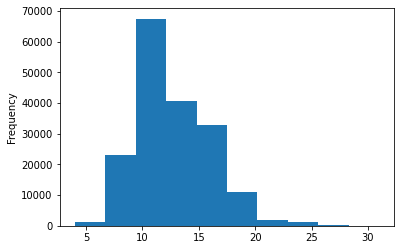

In [18]:
#Distribution of total lines in each article

df_train.total_lines.plot(kind = 'hist')

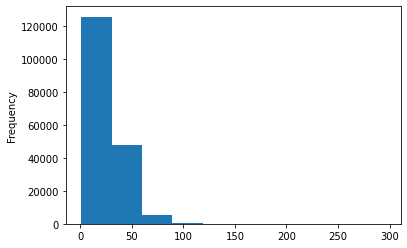

In [19]:
#Distribution of number tokens in each line

df_train.tokens.plot(kind = 'hist')

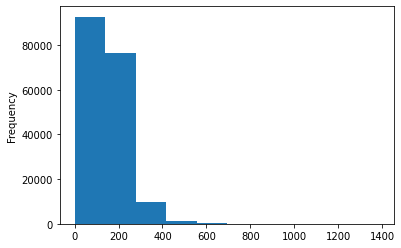

In [20]:
#Number of charcters in each line
df_train.characters.plot(kind = 'hist')

In [21]:
df_train.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

### Get our numerical labels 

In [22]:
classes = df_train.target.unique()
classes

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [23]:
def num_classes(df):
  df['label'] = ['']*len(df)
  for cl, i in zip(classes, range(len(classes))):
    df.loc[df.target == cl, 'label'] = i
  df['label'] = df['label'].astype(int)  
  return df

In [24]:
df_dev = num_classes(df_dev)
df_test = num_classes(df_test)
df_train = num_classes(df_train)

In [25]:
df_train.head()

,target,text,id,line_num,total_lines,tokens,characters,label
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,24293578,0,12,49,281,0
1,METHODS,A total of @ patients with primary knee OA wer...,24293578,1,12,27,137,1
2,METHODS,Outcome measures included pain reduction and i...,24293578,2,12,15,111,1
3,METHODS,Pain was assessed using the visual analog pain...,24293578,3,12,14,65,1
4,METHODS,Secondary outcome measures included the Wester...,24293578,4,12,35,209,1


In [26]:
df_train.dtypes

target         object
text           object
id             object
line_num        int64
total_lines     int64
tokens          int64
characters      int64
label           int64
dtype: object

### Set up train, test and validation datasets

In [27]:
X_train = df_train['text'].tolist()
y_train = df_train['label']
X_test = df_test['text'].tolist()
y_test = df_test['label']
X_val = df_dev['text'].tolist()
y_val = df_dev['label']

In [28]:
enc = OneHotEncoder(sparse=False)
y_train_one_hot =  enc.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_val_one_hot =  enc.transform(y_val.to_numpy().reshape(-1, 1))
y_test_one_hot =  enc.transform(y_test.to_numpy().reshape(-1, 1))

In [29]:
y_train_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [30]:
y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()
y_val = df_dev['label'].tolist()

In [31]:
y_test[:4]

[4, 2, 2, 2]

### Build Base Line Model Logistic Regression (LR) using n-gram features

In [32]:
X_train[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [33]:
X = X_test + X_train

In [34]:
len(X), len(X_train), len(X_test), len(y_train)

(210175, 180040, 30135, 180040)

In [35]:
y_train[:5]

[0, 1, 1, 1, 1]

In [36]:
tfid_vect = TfidfVectorizer()
X_tfid = tfid_vect.fit(X)
X_train_tfid = tfid_vect.transform(X_train)
X_test_tfid = tfid_vect.transform(X_test)

In [37]:
base_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [38]:
#base_model.fit(X_train_tfid, y_train)

KeyboardInterrupt: ignored

### Save Base Model to GD

In [41]:
# save the model to disk
filename = '/content/drive/MyDrive/projects/SPICED/models/SkimLit_base_model.sav'
#pickle.dump(base_model, open(filename, 'wb')) 

### Load Base Model

In [42]:
# load the model from disk
loaded_base_model = pickle.load(open(filename, 'rb'))

### Make predictions

In [43]:
base_pred = loaded_base_model.predict(X_test_tfid)

In [44]:
base_pred[:5], y_test[:5]

(array([4, 1, 1, 1, 2]), [4, 2, 2, 2, 2])

### Save results in DataFrame
accuracy, precision, recall,  f1-score

In [45]:
df_results = pd.DataFrame(columns = ['model', 'accuracy'])

In [46]:
def save_results(model, y_test, y_pred):
  global df_results
  scores = [model, accuracy_score(y_test, y_pred)]
  df_results.loc[len(df_results)] = scores

In [47]:
pd.DataFrame(classification_report(y_test, base_pred, output_dict = True))

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.677976,0.846467,0.853389,0.729773,0.642091,0.797113,0.749939,0.793396
recall,0.522503,0.903001,0.859364,0.696565,0.644573,0.797113,0.725201,0.797113
f1-score,0.590172,0.873821,0.856366,0.712783,0.643330,0.797113,0.735294,0.794113
support,2333.000000,9897.000000,9713.000000,4571.000000,3621.000000,0.797113,30135.000000,30135.000000


In [48]:
save_results('LR_base', y_test, base_pred)
df_results

,model,accuracy
0,LR_base,0.797113


### Naive Bayes Model

In [49]:
nb_model = MultinomialNB()

In [50]:
nb_model.fit(X_train_tfid, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
nb_pred = nb_model.predict(X_test_tfid)

In [52]:
pd.DataFrame(classification_report(y_test, nb_pred, output_dict=True))

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.742389,0.725920,0.759524,0.632556,0.645088,0.718268,0.701095,0.714151
recall,0.135877,0.877236,0.853907,0.581492,0.467827,0.718268,0.583268,0.718268
f1-score,0.229710,0.794437,0.803955,0.605950,0.542340,0.718268,0.595278,0.694902
support,2333.000000,9897.000000,9713.000000,4571.000000,3621.000000,0.718268,30135.000000,30135.000000


In [53]:
save_results('Naive_Bayers', y_test, nb_pred)
df_results

,model,accuracy
0,LR_base,0.797113
1,Naive_Bayers,0.718268


### 1 Model Feed-forward neural network (dense model)

In [54]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, GlobalAveragePooling1D, Flatten, LSTM, GRU, Bidirectional, Conv1D

In [55]:
DIR = 'model_logs'

In [56]:
tokens = 50
vocab_length = 68000

In [57]:
# Create TextVectorization Layer
text_vect = TextVectorization(max_tokens=vocab_length,
                              output_sequence_length = tokens)

In [58]:
text_vect.adapt(X_train)
#Try to adapt to all data X

In [59]:
# Create Embedding Layer
embedding = Embedding(input_dim = vocab_length,
                      output_dim = 128,
                      input_length = tokens)

In [60]:
X_train[1]

'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

In [61]:
text_vect([X_train[1]])

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[   8,   76,    4,   12,    7,   56,  517, 1743,    9,   29,   80,
         744,    4, 2535,    3,   80,   48,   11,   53,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])>

In [62]:
embedding(text_vect([X_train[1]]))

<tf.Tensor: shape=(1, 50, 128), dtype=float32, numpy=
array([[[-0.00600511,  0.03448112, -0.04153514, ...,  0.01293588,
          0.03052542,  0.00815248],
        [-0.00561048,  0.03942223,  0.01199774, ...,  0.02359433,
         -0.02443757,  0.02658052],
        [-0.03109737, -0.00634931, -0.03474804, ..., -0.0432852 ,
         -0.03807454,  0.00901792],
        ...,
        [-0.04696163,  0.03725058,  0.03517136, ...,  0.00423603,
          0.01500383,  0.04683887],
        [-0.04696163,  0.03725058,  0.03517136, ...,  0.00423603,
          0.01500383,  0.04683887],
        [-0.04696163,  0.03725058,  0.03517136, ...,  0.00423603,
          0.01500383,  0.04683887]]], dtype=float32)>

### Creating Datasets
https://www.tensorflow.org/guide/data

https://www.tensorflow.org/guide/data_performance

In [63]:
# Turn our data into TensorFlow Datasets
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val_one_hot))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

In [64]:
# Take the TensorSliceDataset's and turn them into prefetched batches
ds_train = ds_train.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)

ds_train

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [194]:
K.clear_session()

In [204]:
inputs = Input(shape = (1,), dtype = 'string')
x = text_vect(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)

In [205]:
model_1 = Model(inputs, outputs)

In [206]:
model_1.compile(optimizer='adam', metrics='accuracy', loss = 'categorical_crossentropy')

In [207]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 128)           8704000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 8,721,157
Trainable params: 8,721,157
Non-trainable params: 0
_________________________________________________

In [209]:
history_1 = model_1.fit(ds_train, epochs = 5,
                        validation_data = ds_val,
                        callbacks = create_tf_board_callback(DIR, 'model_1_base_dense'))

Saving TensorBoard log files to model_logs/model_1_base_dense/20210721-063505
Epoch 1/5
5627/5627 [==============================] - 487s 87ms/step - loss: 0.5758 - accuracy: 0.7872 - val_loss: 0.5356 - val_accuracy: 0.8025
Epoch 2/5
5627/5627 [==============================] - 484s 86ms/step - loss: 0.4509 - accuracy: 0.8362 - val_loss: 0.5496 - val_accuracy: 0.8004
Epoch 3/5
5627/5627 [==============================] - 481s 85ms/step - loss: 0.3819 - accuracy: 0.8632 - val_loss: 0.5893 - val_accuracy: 0.7957
Epoch 4/5
5627/5627 [==============================] - 486s 86ms/step - loss: 0.3246 - accuracy: 0.8856 - val_loss: 0.6471 - val_accuracy: 0.7894
Epoch 5/5
5627/5627 [==============================] - 486s 86ms/step - loss: 0.2733 - accuracy: 0.9048 - val_loss: 0.7175 - val_accuracy: 0.7838


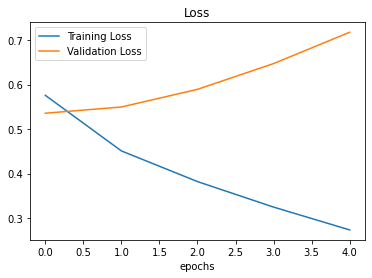

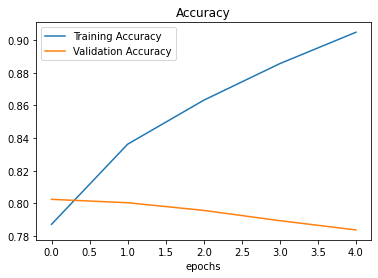

In [211]:
plot_loss_curves(history_1)

In [217]:
model_1.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_1/assets


In [ ]:
load_model_1 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_1')

In [ ]:
load_model_1.evaluate(ds_val)

In [ ]:
prob_1 = load_model_1.predict(X_test)

In [ ]:
prob_1.shape

In [ ]:
pred_1 = tf.argmax(prob_1, axis = 1)

In [ ]:
pred_1[:10], y_test[:10]

In [ ]:
save_results('model_1_128_dense',y_test, pred_1)

In [ ]:
df_results

### Model2 Conv1D

In [234]:
inputs = Input(shape = (1,), dtype='string')
x = text_vect(inputs)
x = embedding(x)
x = Conv1D(64, 5, padding='same', activation='relu')(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(len(classes), activation='softmax')(x)
model_2 = Model(inputs, outputs)

In [238]:
model_2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = 'accuracy')

In [239]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 128)           8704000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 64)            41024     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 8,745,349
Trainable params: 8,745,349
Non-trainable params: 0
_________________________________________________

In [241]:
history_2 = model_2.fit(ds_train, epochs = 3,
                        steps_per_epoch = int(0.1*len(ds_train)),
                        validation_data = ds_val,
                        validation_steps = int(0.1*len(ds_val)),
                        callbacks = create_tf_board_callback(DIR, 'model_2_conv1d'))

Saving TensorBoard log files to model_logs/model_2_conv1d/20210721-073917
Epoch 1/3
562/562 [==============================] - 49s 87ms/step - loss: 0.5336 - accuracy: 0.8253 - val_loss: 0.6101 - val_accuracy: 0.7876
Epoch 2/3
562/562 [==============================] - 48s 86ms/step - loss: 0.3831 - accuracy: 0.8762 - val_loss: 0.6297 - val_accuracy: 0.7783
Epoch 3/3
562/562 [==============================] - 48s 86ms/step - loss: 0.3619 - accuracy: 0.8854 - val_loss: 0.6369 - val_accuracy: 0.7809


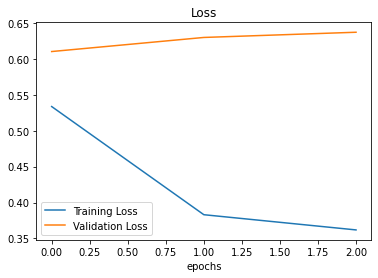

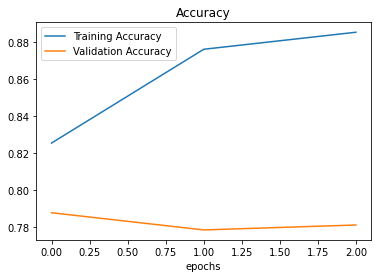

In [242]:
plot_loss_curves(history_2)

In [243]:
model_2.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_2/assets


In [ ]:
load_model_2 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_2')

In [ ]:
load_model_2.evaluate(ds_val)

In [ ]:
prob_2 = load_model_2.predict(X_test)

In [ ]:
pred_2 = tf.argmax(prob_2, axis = 1)

In [ ]:
pred_2[10:20], y_test[10:20]

In [ ]:
save_results('model_2_64_conv1d',y_test, pred_2)

In [ ]:
df_results

## Features extraction with pretrained embedding model
We will use universal-sentence-encoder


In [256]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133019 -0.06338634 -0.016075   ... -0.0324278  -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652431  0.01573778 ...  0.00976658  0.03170119
   0.01788118]], shape=(2, 512), dtype=float32)


In [292]:
use_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                           input_shape = [],
                           dtype = tf.string,
                           trainable = False)

In [293]:
inputs = Input(shape = [], dtype = tf.string)
x = use_layer(inputs)
x = Dense(128, activation = 'relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)

In [294]:
model_3 = Model(inputs, outputs)

In [295]:
model_3.compile(optimizer='adam', metrics = 'accuracy', loss = 'categorical_crossentropy')

In [296]:
model_3.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None,)]                 0         
_________________________________________________________________
keras_layer_3 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [297]:
history_3 = model_3.fit(ds_train, epochs = 5, 
                        validation_data = ds_val,
                        validation_steps = int(0.1*len(ds_val)),
                        callbacks = create_tf_board_callback(DIR, 'model_3_use_128'))

Saving TensorBoard log files to model_logs/model_3_use_128/20210721-081646
Epoch 1/5
5627/5627 [==============================] - 70s 12ms/step - loss: 0.7293 - accuracy: 0.7220 - val_loss: 0.6507 - val_accuracy: 0.7573
Epoch 2/5
5627/5627 [==============================] - 64s 11ms/step - loss: 0.6338 - accuracy: 0.7598 - val_loss: 0.6169 - val_accuracy: 0.7673
Epoch 3/5
5627/5627 [==============================] - 64s 11ms/step - loss: 0.5992 - accuracy: 0.7734 - val_loss: 0.6007 - val_accuracy: 0.7769
Epoch 4/5
5627/5627 [==============================] - 65s 11ms/step - loss: 0.5770 - accuracy: 0.7825 - val_loss: 0.5948 - val_accuracy: 0.7779
Epoch 5/5
5627/5627 [==============================] - 65s 12ms/step - loss: 0.5607 - accuracy: 0.7884 - val_loss: 0.5926 - val_accuracy: 0.7786


In [298]:
model_3.save('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/projects/SPICED/models/SkimLit_model_3/assets


In [299]:
load_model_3 = tf.keras.models.load_model('/content/drive/MyDrive/projects/SPICED/models/SkimLit_model_3')

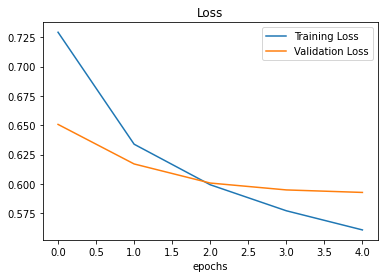

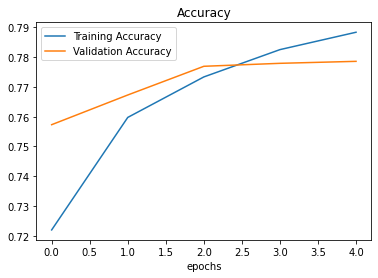

In [300]:
plot_loss_curves(history_3)

In [301]:
prob_3 = load_model_3.predict(X_test)

In [290]:
pred_3 = tf.argmax(prob_3, axis = 1)

In [304]:
save_results('model_3_use_128',y_test, pred_3)

In [305]:
df_results

,model,accuracy
0,LR_base,0.797113
1,Naive_Bayers,0.718268
2,model_1_128_dense,0.776572
3,model_2_64_conv1d,0.778264
4,model_2_64_conv1d,0.778264
5,model_3_use_128,0.778264
6,model_3_use_128,0.740733


### Model 4 Conv1D with character embeddings

In [316]:
text = 'Model 4 Conv1D'

In [317]:
list(text)

['M', 'o', 'd', 'e', 'l', ' ', '4', ' ', 'C', 'o', 'n', 'v', '1', 'D']

In [315]:
# Split our text to characters
def split_to_char(text):
  return ' '.join(list(text))

In [324]:
split_to_char(text)

'M o d e l   4   C o n v 1 D'

In [327]:
X_train_char = [split_to_char(sentence) for sentence in X_train]
X_val_char = [split_to_char(sentence) for sentence in X_val]
X_test_char = [split_to_char(sentence) for sentence in X_test]

In [328]:
X_train_char[:1]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .']

In [329]:
char_num = 25
char_tokens = 50

In [330]:
char_vect = TextVectorization(max_tokens=char_tokens,
                              output_sequence_length = char_num)

In [331]:
char_vect.adapt(X_train_char)

In [339]:
len = [len(sent) for sent in X_train]
print(np.mean(len))

149.3662574983337


(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

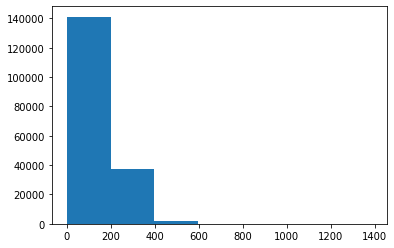

In [343]:
plt.hist(len, bins=7)

In [345]:
#Find what character length within 95% of our dataset
char_len_95 = int(np.percentile(len, 95))
char_len_95

290

In [352]:
#Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits

In [354]:
alphabet

'abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'